In [103]:
from ultralytics import YOLO
MODEL_NAME = "best-reduced-imagery.pt"
MODEL_PATH = f"G:/Google Drive/ml/minitracking"
#SOURCE_VIDEO_PATH = f"{HOME}/drive/MyDrive/ml/minitracking/WIN_20230923_13_17_21_Pro.mp4"

model = YOLO(f"{MODEL_PATH}/{MODEL_NAME}")
model.fuse()

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0]

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs


In [104]:
import cv2

print("Starting video capture...")
capture = cv2.VideoCapture(0)
print("Video capture online...")

Starting video capture...
Video capture online...


In [117]:
import cv2
import numpy as np
import math
import sys

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def is_rectish(contour):
    contour_len = len(contour)
    max_angle_delta_deg = 55
    
    # Needs to be 4-sided
    if contour_len != 4:
        return False
    
    # Future better way: get "top-left" and go clockwise, then ensure that
    # top are obtuse, bottom are acute due to perspective
    
    p1 = contour[0]
    p2 = contour[1]
    p3 = contour[2]
    p4 = contour[3]
    
    angles = (
        math.degrees(angle_between(p2 - p1, p4 - p1)),
        math.degrees(angle_between(p1 - p2, p3 - p2)),
        math.degrees(angle_between(p4 - p3, p2 - p3)),
        math.degrees(angle_between(p3 - p4, p1 - p4)),
    )
    
    for angle in angles:
        if abs(90 - angle) > max_angle_delta_deg:
            return False
        
    return True

def reorder_upper_left(points):
    closest_dist = sys.float_info.max
    closest_idx = -1
    for idx, point in enumerate(points):
        dist = math.sqrt(math.pow(point[0],2) + math.pow(point[1],2))
        if dist < closest_dist:
            closest_dist = dist
            closest_idx = idx
    
    for i in range(0, closest_idx):
        point = points[0]
        points = np.delete(points, 0, 0)
        points = np.append(points, [point], axis=0)
        
    return points
        

def detect_field(img, min_area_ratio, max_area_ratio):
    # converting image into grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    area = img.shape[0] * img.shape[1]
    center_point = (round(img.shape[0] / 2), round(img.shape[1] / 2))
    
    _, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)

    # using a findContours() function
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    contours_sorted = sorted(contours, key=lambda x: cv2.contourArea(x) / area, reverse=True)
    for contour in contours_sorted:       
        contour_area = cv2.contourArea(contour)
        if contour_area / area > min_area_ratio and contour_area / area < max_area_ratio and cv2.pointPolygonTest(contour, center_point, False) == 1.0:
            # cv2.approxPloyDP() function to approximate the shape
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            while len(approx) > 4:
                epsilon *= 1.1
                approx = cv2.approxPolyDP(contour, epsilon, True)
            
            approx = approx[:,0]
            approx = reorder_upper_left(approx)
            
            if not is_rectish(approx):
                continue

            M = cv2.moments(approx)
            if M['m00'] == 0.0:
                continue
            
            return approx

    return np.empty(0)

def get_pct_along_field(field, center):
    # Assume that field is drawn from upper left, counterclockwise, with 4 points
    return False


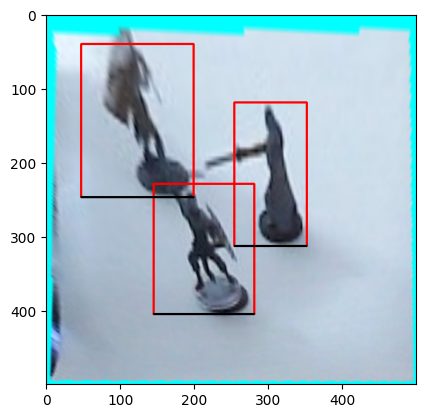

Field: [[227 305]
 [124 411]
 [419 435]
 [363 302]]


0: 480x640 3 miniatures, 3402.5ms
Speed: 3.1ms preprocess, 3402.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)



KeyboardInterrupt: 

In [155]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

has_frame, frame = capture.read()
if not has_frame:
    print('Can\'t get frame')

min_area_ratio = 0
max_area_ratio = 1.0

positions = []
visible_field = []

while True:
    has_frame, frame = capture.read()
    if not has_frame:
        print('Can\'t get frame')
        break
    
    field = detect_field(frame, min_area_ratio, max_area_ratio)
    print(f"Field: {field}")
    if field.any():
        cv2.drawContours(frame, [field], -1, (0,255,255), 3)
        
        dst_pts = np.array([[0,0],[0,500],[500,500],[500,0]])
        M, mask = cv2.findHomography(field, dst_pts)
        frame_mod = cv2.warpPerspective(frame, M, (500,500))
        
        results = model(frame)
        for result in results:
            xyxys = result.boxes.xyxy.cpu().numpy(),
            for xyxy in xyxys[0]:
                xyxy_i = xyxy.reshape(2,2)
                xyxy_m = cv2.perspectiveTransform(np.array([xyxy_i]), M)[0,:,:].flatten()            
                cv2.rectangle(frame_mod, (round(xyxy_m[0]), round(xyxy_m[1])), (round(xyxy_m[2]), round(xyxy_m[3])), (255,0,0), 2)
                cv2.line(frame_mod, (round(xyxy_m[0]), round(xyxy_m[3])), (round(xyxy_m[2]), round(xyxy_m[3])), (0,0,0), 2)       
        plt.imshow(frame_mod)
    else:
        plt.imshow(frame)
        
    clear_output(wait=True)
    plt.show()
